In [7]:
import numpy as np
import torch
from rl_bas.dynamics import Model
from rl_bas.replay_memory import ReplayMemory
import matplotlib.pyplot as plt

In [6]:
# from torch.utils.tensorboard import SummaryWriter
# %load_ext tensorboard 
# %tensorboard --logdir './tensorboard_log_dir' --host=0.0.0.0 --port 6011 --reload_multifile True

In [8]:
def train(agent, env, model, seed, num_episode, QbasVal):
    # configuration
    model_based = True
    horizon = 1
    batch_size = 256
    rollout_batch_size = 5
    updates_per_step = 2
    experiment = False
    # memory
    memory = ReplayMemory(1000000, seed)
    memory_model = ReplayMemory(1000000, seed)
    
    # training setup
    total_steps = 0
    updates = 0
    Qbas = QbasVal
    model_update_count = int(batch_size * 2.5) # must be smaller than episode_step
    hist_pi = np.array([0, 0, 0, 0])
    hist_r = []
    hist_episode_r = []
    tmp_reward = np.array([0])
    hist_state = []
    tmp_state = np.array([env.initial_state])
    hist_cost = [] #env.initial_state[0, 0:2] - env.goal_pos
    tmp_cost = np.array([np.linalg.norm(env.initial_state - env.desired_pos, axis=0)])
    hist_action = []
    tmp_action = np.array([0, 0])
    hist_episode = []

    for episode in range(num_episode):
        episode_reward = 0
        episode_cost = 0
        episode_step = 0
        reward = 0
        done = False
        obs, info = env.reset()
        
        tmp_reward = np.array([0])
        tmp_norm_reward = np.array([0])
        tmp_state = np.array([env.initial_state])
        diff = env.initial_state[:4] - env.desired_pos[:4]
        if env.mode == 'BaS':
            tmp_cost = np.array([diff @ np.diag([1, 1, 0, 1]) @ diff])
        else: # BF
            tmp_cost = np.array([diff @ np.diag([1, 1, 0]) @ diff])
        tmp_action = np.array([0, 0])
        
        while not done:
            state = model.get_state(obs)
            
            if episode_step % 50 == 0:
                print("Episodes: {}, total_numsteps: {}, episode steps: {}, reward: {}, curr. cost: {}, memory: {}, memory_model: {}"
                  .format(episode, total_steps, episode_step, round(reward, 3), round(info.get('cost', 0), 3), len(memory), len(memory_model)))
                                      
            if model_based and episode_step % 5 == 0 and len(memory) > model_update_count:
                memory_model = generate_model_rollout(env, memory_model, memory, 
                                              agent, model, Qbas, horizon = horizon, batch_size=min(len(memory), 5 * rollout_batch_size))
                
            if len(memory) + len(memory_model) * model_based > batch_size:
                for i in range(updates_per_step):
                    if model_based:
                        ratio = max(min(0.3, len(memory)/batch_size), 
                                    1 - len(memory_model) / batch_size)
                        
                        critic_1_loss, critic_2_loss, policy_loss, entrophy_loss, alpha = agent.update_parameters(memory, batch_size, 
                                                                                                 updates, model, 
                                                                                                 memory_model, ratio)
                        hist_pi = np.vstack((hist_pi, np.array([critic_1_loss, critic_2_loss, policy_loss, entrophy_loss])))
                        
                        if experiment:
                            print("Episodes: {}, total_numsteps: {}, episode steps: {}, critic 1 loss: {}, critic 2 loss: {}, policy loss: {}, entrophy loss: {}"
                                .format(episode, total_steps, episode_step, round(critic_1_loss, 3), round(critic_2_loss, 3), round(policy_loss, 3), round(entrophy_loss, 3)))
                        
                    else:
                        critic_1_loss, critic_2_loss, policy_loss, entrophy_loss, alpha = agent.update_parameters(memory, batch_size, 
                                                                                                 updates, model)
                        hist_pi = np.vstack((hist_pi, np.array([critic_1_loss, critic_2_loss,policy_loss, entrophy_loss])))
                        
                    updates += 1
                    
            action = agent.generate_action(obs, model)
            next_obs, reward, done, next_info = env.step(action)
            episode_step += 1
            total_steps += 1
            episode_reward += reward
            episode_cost += next_info.get('cost', 0)
            mask = 1 if episode_step == env.max_episode_steps else float(not done)
            memory.push(obs, action, reward, next_obs, mask, t=episode_step*env.dt, next_t=(episode_step+1)*env.dt)
            
            tmp_norm_reward = np.vstack((tmp_norm_reward, episode_reward))
            tmp_state = np.vstack((tmp_state, state))
            tmp_cost = np.vstack((tmp_cost, next_info.get('cost', 0)))
            tmp_action = np.vstack((tmp_action, action))
            tmp_reward = np.vstack((tmp_reward, reward))    

            obs = next_obs
            info = next_info

        hist_state.append(tmp_state)
        hist_cost.append(tmp_cost)
        hist_action.append(tmp_action)   
        hist_r.append(tmp_reward)
        hist_episode_r.append(tmp_norm_reward)
        
        if episode % 20 == 0:
            avg_reward = 0
            avg_cost = 0
            test_episodes = 5
            for _ in range(test_episodes):
                obs, info = env.reset()
                episode_reward = 0
                episode_cost = 0
                done = False
                while not done:
                    action = agent.generate_action(obs, model)
                    next_obs, reward, done, next_info = env.step(action)
                    episode_reward += reward
                    episode_cost += next_info.get('cost', 0)
                    obs = next_obs
                    info = next_info
                
                avg_reward += episode_reward
                avg_cost += episode_cost
                
            avg_reward /= test_episodes
            avg_cost /= test_episodes
            
            print("----------------------------------------")
            print("Evaluation Episodes: {}, Avg. Reward: {}, Avg. Cost: {}".format(test_episodes, round(avg_reward, 2), round(avg_cost, 2)))
            print("----------------------------------------")   
            
            if episode > 1:
                fig, ax = plt.subplots(1, 5, figsize=(20,5))
                ax[0].plot(hist_pi[:, 0])
                ax[0].set_ylabel("critic_1_loss")
                ax[1].plot(hist_pi[:, 1])
                ax[1].set_ylabel("critic_2_loss")
                ax[2].plot(hist_pi[:, 2])
                ax[2].set_ylabel("policy_loss")
                ax[3].plot(hist_pi[:, 3])
                ax[3].set_ylabel("entrophy_loss")
                ax[4].plot(hist_r[episode])
                ax[4].set_ylabel("reward")
                plt.show()
                
                fig2, ax2 = plt.subplots()
                ax2.cla() # clear things for fresh plot
                ax2.set_ylim((-2, 5))
                ax2.set_xlim((-2, 5))
                for n_obs in range(3):
                    circle = plt.Circle((env.obs_loc[n_obs][:2]), env.obs_loc[n_obs][2], color='r')
                    ax2.add_patch(circle)
                init_point = plt.Circle((env.initial_state[:2]), 0.05, color='k')
                des_point = plt.Circle((env.desired_pos[:2]), 0.05, color='g')
                            
                #fig.savefig('plotcircles2.png')
                ax2.add_patch(des_point)   
                ax2.add_patch(init_point)
                ax2.plot(hist_state[episode][:, 0], hist_state[episode][:, 1], 'b')
                plt.show()
                
        hist_episode = np.append(hist_episode, int(episode_step))
        if total_steps > 4e5:
            break
    return hist_state, hist_action, hist_pi, hist_r, hist_episode_r, hist_cost, hist_episode

In [5]:
torch.cuda.is_available()

True

In [9]:
from rl_bas.SAC import Agent
from myEnv import *
from rl_bas.obstacle_2d import Obstacles2D

#obs_info = np.array([[0.5, 1.5, 0.3], [1.5, 0.2, 0.25], [2.5, 2.1, 0.32]])
obs_info = Obstacles2D(n = 3, obst_course_type='manual_obstacles1', number_of_obstacles=3)
obstacle_update = True
mode = 'BaS' # 'BaS' or 'BF'
Qbas = 1.0
env = myEnv(np.array([0.0, 0.0, 0.0]), np.array([3.0, 3.0, 0.0]), obs_info, mode, Qbas, obstacle_update)

model = Model(env, obs_info)
gamma = 0.99 # discount
tau = 0.005 #interpolation factor in averaging for target network.
alpha = 0.2 # entropy regularization coefficient. 
action_space = env.action_space
learning_rate = 3e-4 
num_inputs = env.observation_space.shape[0]
num_hidden = 256
agent = Agent(gamma, tau, alpha, action_space, learning_rate, num_inputs, num_hidden)
num_episode = 200
# Random Seed
seed = 12345
if seed > 0:
    env.seed(seed)
    env.action_space.seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
    model.seed(seed)        

Episodes: 0, total_numsteps: 0, episode steps: 0, reward: 0, curr. cost: 0, memory: 0, memory_model: 0
Episodes: 0, total_numsteps: 50, episode steps: 50, reward: -4.143, curr. cost: 4.287, memory: 50, memory_model: 0
Episodes: 0, total_numsteps: 100, episode steps: 100, reward: -4.213, curr. cost: 4.314, memory: 100, memory_model: 0
Episodes: 0, total_numsteps: 150, episode steps: 150, reward: -4.256, curr. cost: 4.339, memory: 150, memory_model: 0
Episodes: 0, total_numsteps: 200, episode steps: 200, reward: -4.333, curr. cost: 4.406, memory: 200, memory_model: 0
Episodes: 0, total_numsteps: 250, episode steps: 250, reward: -4.411, curr. cost: 4.476, memory: 250, memory_model: 0
Episodes: 0, total_numsteps: 300, episode steps: 300, reward: -4.436, curr. cost: 4.496, memory: 300, memory_model: 0
Episodes: 0, total_numsteps: 350, episode steps: 350, reward: -4.487, curr. cost: 4.542, memory: 350, memory_model: 0
Episodes: 0, total_numsteps: 400, episode steps: 400, reward: -4.507, curr

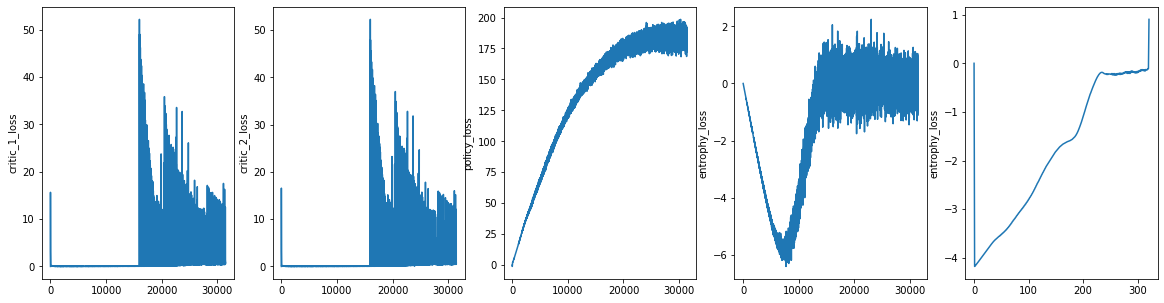

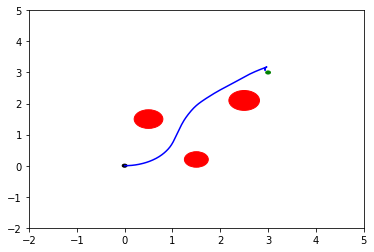

Episodes: 21, total_numsteps: 15991, episode steps: 0, reward: 0, curr. cost: 0, memory: 15991, memory_model: 76825
Episodes: 21, total_numsteps: 16041, episode steps: 50, reward: -3.515, curr. cost: 3.57, memory: 16041, memory_model: 77075
Episodes: 21, total_numsteps: 16091, episode steps: 100, reward: -2.89, curr. cost: 2.933, memory: 16091, memory_model: 77325
Episodes: 21, total_numsteps: 16141, episode steps: 150, reward: -1.873, curr. cost: 1.9, memory: 16141, memory_model: 77575
Episodes: 21, total_numsteps: 16191, episode steps: 200, reward: -1.101, curr. cost: 1.117, memory: 16191, memory_model: 77825
Episodes: 21, total_numsteps: 16241, episode steps: 250, reward: -0.274, curr. cost: 0.278, memory: 16241, memory_model: 78075
Episodes: 21, total_numsteps: 16291, episode steps: 300, reward: -0.256, curr. cost: 0.26, memory: 16291, memory_model: 78325
Episodes: 21, total_numsteps: 16341, episode steps: 350, reward: -0.24, curr. cost: 0.244, memory: 16341, memory_model: 78575
Ep

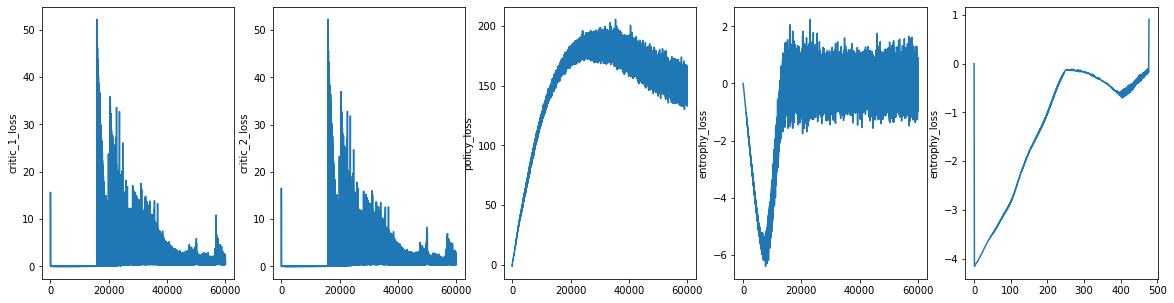

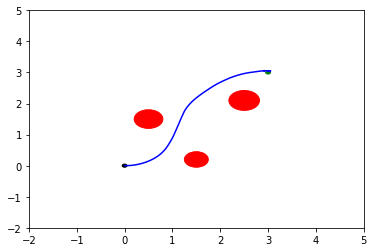

Episodes: 41, total_numsteps: 30291, episode steps: 0, reward: 0, curr. cost: 0, memory: 30291, memory_model: 148425
Episodes: 41, total_numsteps: 30341, episode steps: 50, reward: -3.513, curr. cost: 3.556, memory: 30341, memory_model: 148675
Episodes: 41, total_numsteps: 30391, episode steps: 100, reward: -2.869, curr. cost: 2.904, memory: 30391, memory_model: 148925
Episodes: 41, total_numsteps: 30441, episode steps: 150, reward: -1.82, curr. cost: 1.842, memory: 30441, memory_model: 149175
Episodes: 41, total_numsteps: 30491, episode steps: 200, reward: -1.02, curr. cost: 1.033, memory: 30491, memory_model: 149425
Episodes: 41, total_numsteps: 30541, episode steps: 250, reward: -0.133, curr. cost: 0.135, memory: 30541, memory_model: 149675
Episodes: 41, total_numsteps: 30591, episode steps: 300, reward: -0.122, curr. cost: 0.124, memory: 30591, memory_model: 149925
Episodes: 41, total_numsteps: 30641, episode steps: 350, reward: -0.125, curr. cost: 0.127, memory: 30641, memory_mode

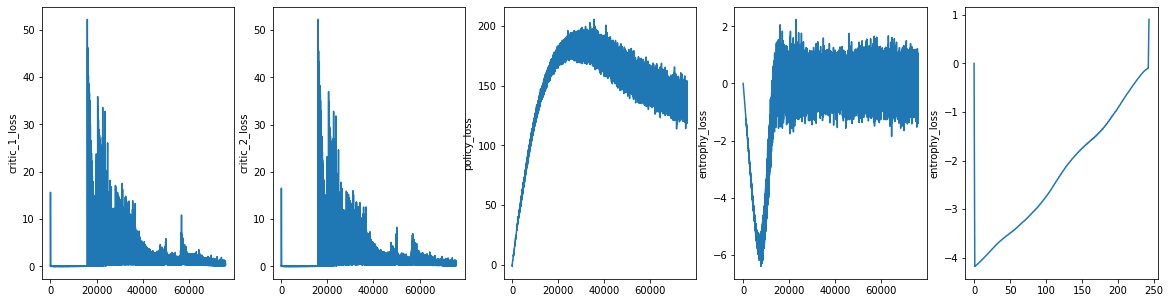

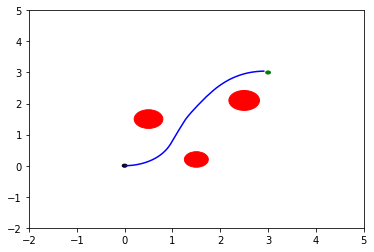

Episodes: 61, total_numsteps: 38240, episode steps: 0, reward: 0, curr. cost: 0, memory: 38240, memory_model: 188350
Episodes: 61, total_numsteps: 38290, episode steps: 50, reward: -3.518, curr. cost: 3.562, memory: 38290, memory_model: 188600
Episodes: 61, total_numsteps: 38340, episode steps: 100, reward: -2.781, curr. cost: 2.816, memory: 38340, memory_model: 188850
Episodes: 61, total_numsteps: 38390, episode steps: 150, reward: -1.78, curr. cost: 1.802, memory: 38390, memory_model: 189100
Episodes: 61, total_numsteps: 38440, episode steps: 200, reward: -0.965, curr. cost: 0.977, memory: 38440, memory_model: 189350
Episodes: 62, total_numsteps: 38483, episode steps: 0, reward: 0, curr. cost: 0, memory: 38483, memory_model: 189575
Episodes: 62, total_numsteps: 38533, episode steps: 50, reward: -3.501, curr. cost: 3.545, memory: 38533, memory_model: 189825
Episodes: 62, total_numsteps: 38583, episode steps: 100, reward: -2.755, curr. cost: 2.79, memory: 38583, memory_model: 190075
Ep

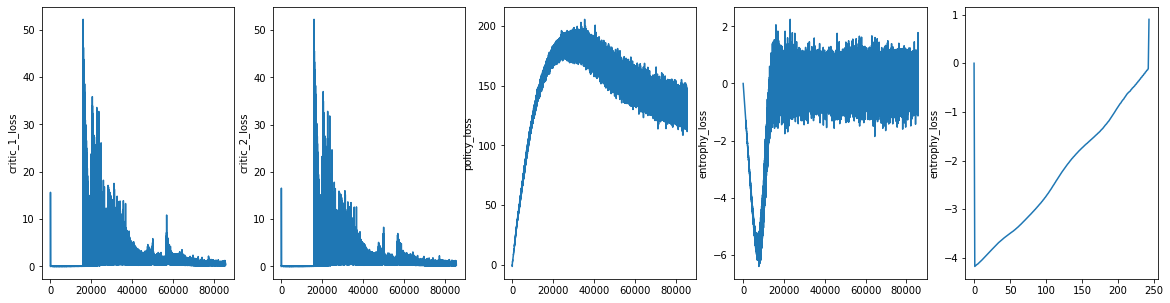

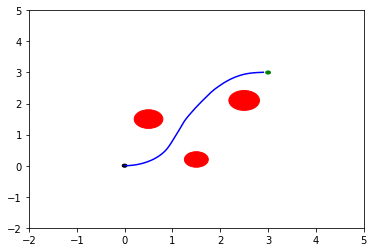

Episodes: 81, total_numsteps: 43101, episode steps: 0, reward: 0, curr. cost: 0, memory: 43101, memory_model: 212925
Episodes: 81, total_numsteps: 43151, episode steps: 50, reward: -3.498, curr. cost: 3.54, memory: 43151, memory_model: 213175
Episodes: 81, total_numsteps: 43201, episode steps: 100, reward: -2.72, curr. cost: 2.754, memory: 43201, memory_model: 213425
Episodes: 81, total_numsteps: 43251, episode steps: 150, reward: -1.76, curr. cost: 1.782, memory: 43251, memory_model: 213675
Episodes: 81, total_numsteps: 43301, episode steps: 200, reward: -0.886, curr. cost: 0.897, memory: 43301, memory_model: 213925
Episodes: 82, total_numsteps: 43346, episode steps: 0, reward: 0, curr. cost: 0, memory: 43346, memory_model: 214150
Episodes: 82, total_numsteps: 43396, episode steps: 50, reward: -3.502, curr. cost: 3.544, memory: 43396, memory_model: 214400
Episodes: 82, total_numsteps: 43446, episode steps: 100, reward: -2.705, curr. cost: 2.739, memory: 43446, memory_model: 214650
Epi

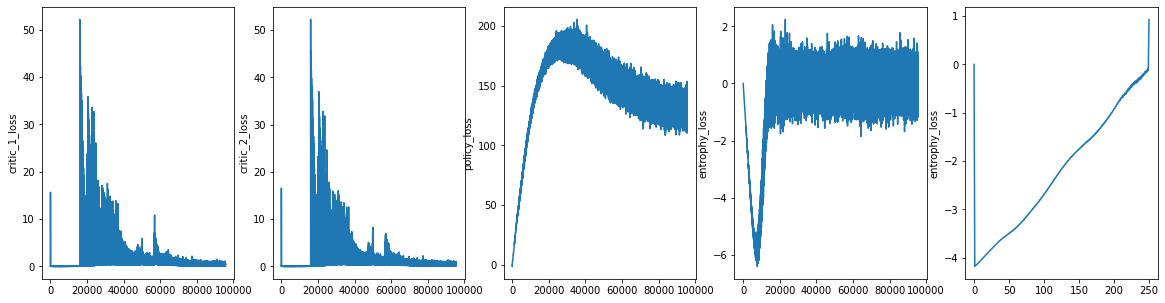

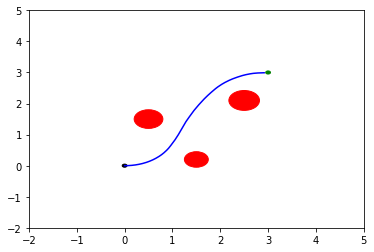

Episodes: 101, total_numsteps: 48066, episode steps: 0, reward: 0, curr. cost: 0, memory: 48066, memory_model: 237900
Episodes: 101, total_numsteps: 48116, episode steps: 50, reward: -3.494, curr. cost: 3.538, memory: 48116, memory_model: 238150
Episodes: 101, total_numsteps: 48166, episode steps: 100, reward: -2.714, curr. cost: 2.748, memory: 48166, memory_model: 238400
Episodes: 101, total_numsteps: 48216, episode steps: 150, reward: -1.76, curr. cost: 1.783, memory: 48216, memory_model: 238650
Episodes: 101, total_numsteps: 48266, episode steps: 200, reward: -0.917, curr. cost: 0.929, memory: 48266, memory_model: 238900
Episodes: 102, total_numsteps: 48313, episode steps: 0, reward: 0, curr. cost: 0, memory: 48313, memory_model: 239150
Episodes: 102, total_numsteps: 48363, episode steps: 50, reward: -3.49, curr. cost: 3.534, memory: 48363, memory_model: 239400
Episodes: 102, total_numsteps: 48413, episode steps: 100, reward: -2.686, curr. cost: 2.72, memory: 48413, memory_model: 23

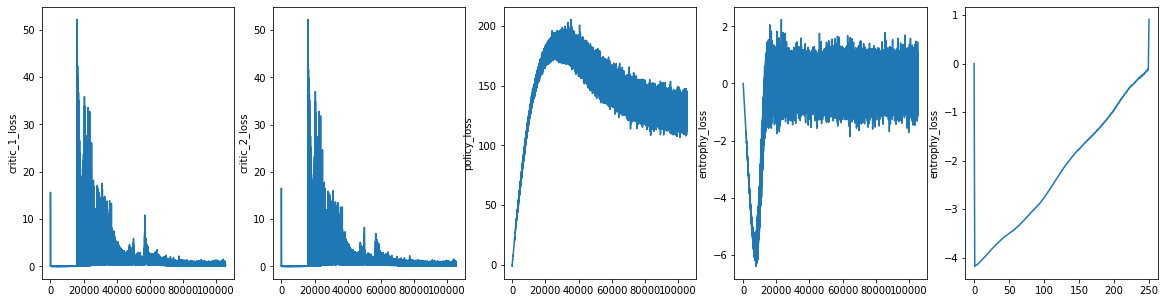

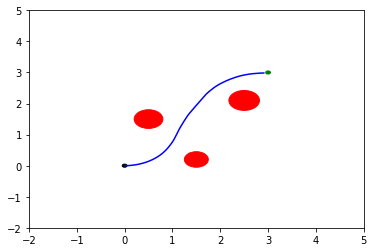

Episodes: 121, total_numsteps: 53038, episode steps: 0, reward: 0, curr. cost: 0, memory: 53038, memory_model: 262975
Episodes: 121, total_numsteps: 53088, episode steps: 50, reward: -3.494, curr. cost: 3.538, memory: 53088, memory_model: 263225
Episodes: 121, total_numsteps: 53138, episode steps: 100, reward: -2.761, curr. cost: 2.796, memory: 53138, memory_model: 263475
Episodes: 121, total_numsteps: 53188, episode steps: 150, reward: -1.747, curr. cost: 1.769, memory: 53188, memory_model: 263725
Episodes: 121, total_numsteps: 53238, episode steps: 200, reward: -0.877, curr. cost: 0.888, memory: 53238, memory_model: 263975
Episodes: 122, total_numsteps: 53285, episode steps: 0, reward: 0, curr. cost: 0, memory: 53285, memory_model: 264225
Episodes: 122, total_numsteps: 53335, episode steps: 50, reward: -3.503, curr. cost: 3.547, memory: 53335, memory_model: 264475
Episodes: 122, total_numsteps: 53385, episode steps: 100, reward: -2.728, curr. cost: 2.762, memory: 53385, memory_model:

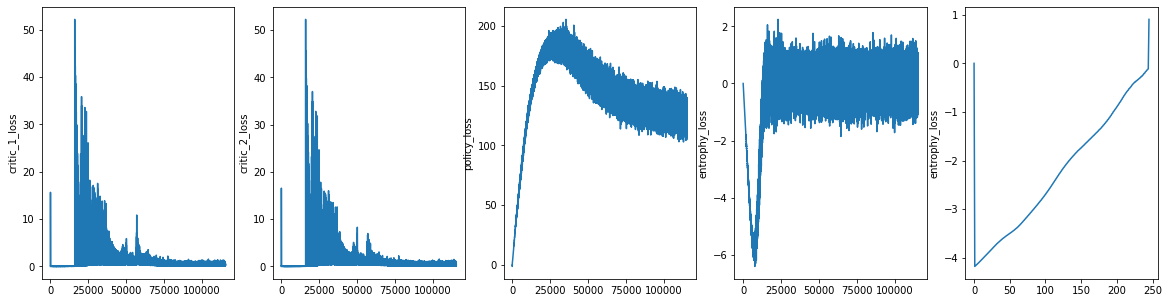

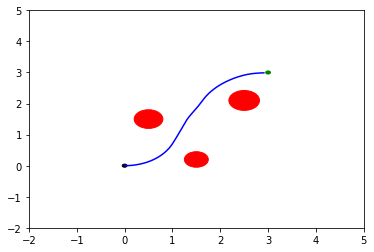

Episodes: 141, total_numsteps: 57961, episode steps: 0, reward: 0, curr. cost: 0, memory: 57961, memory_model: 287825
Episodes: 141, total_numsteps: 58011, episode steps: 50, reward: -3.499, curr. cost: 3.542, memory: 58011, memory_model: 288075
Episodes: 141, total_numsteps: 58061, episode steps: 100, reward: -2.703, curr. cost: 2.737, memory: 58061, memory_model: 288325
Episodes: 141, total_numsteps: 58111, episode steps: 150, reward: -1.766, curr. cost: 1.789, memory: 58111, memory_model: 288575
Episodes: 141, total_numsteps: 58161, episode steps: 200, reward: -0.925, curr. cost: 0.937, memory: 58161, memory_model: 288825
Episodes: 142, total_numsteps: 58207, episode steps: 0, reward: 0, curr. cost: 0, memory: 58207, memory_model: 289075
Episodes: 142, total_numsteps: 58257, episode steps: 50, reward: -3.506, curr. cost: 3.55, memory: 58257, memory_model: 289325
Episodes: 142, total_numsteps: 58307, episode steps: 100, reward: -2.705, curr. cost: 2.738, memory: 58307, memory_model: 

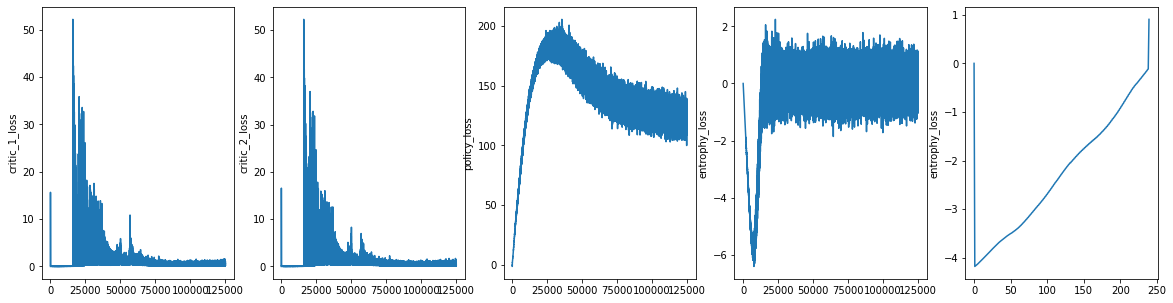

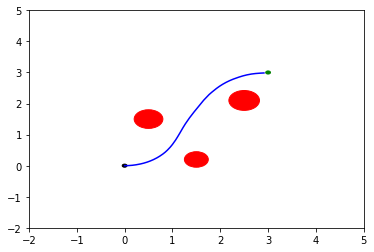

Episodes: 161, total_numsteps: 62811, episode steps: 0, reward: 0, curr. cost: 0, memory: 62811, memory_model: 312300
Episodes: 161, total_numsteps: 62861, episode steps: 50, reward: -3.499, curr. cost: 3.541, memory: 62861, memory_model: 312550
Episodes: 161, total_numsteps: 62911, episode steps: 100, reward: -2.696, curr. cost: 2.729, memory: 62911, memory_model: 312800
Episodes: 161, total_numsteps: 62961, episode steps: 150, reward: -1.756, curr. cost: 1.778, memory: 62961, memory_model: 313050
Episodes: 161, total_numsteps: 63011, episode steps: 200, reward: -0.902, curr. cost: 0.914, memory: 63011, memory_model: 313300
Episodes: 162, total_numsteps: 63051, episode steps: 0, reward: 0, curr. cost: 0, memory: 63051, memory_model: 313500
Episodes: 162, total_numsteps: 63101, episode steps: 50, reward: -3.508, curr. cost: 3.55, memory: 63101, memory_model: 313750
Episodes: 162, total_numsteps: 63151, episode steps: 100, reward: -2.742, curr. cost: 2.775, memory: 63151, memory_model: 

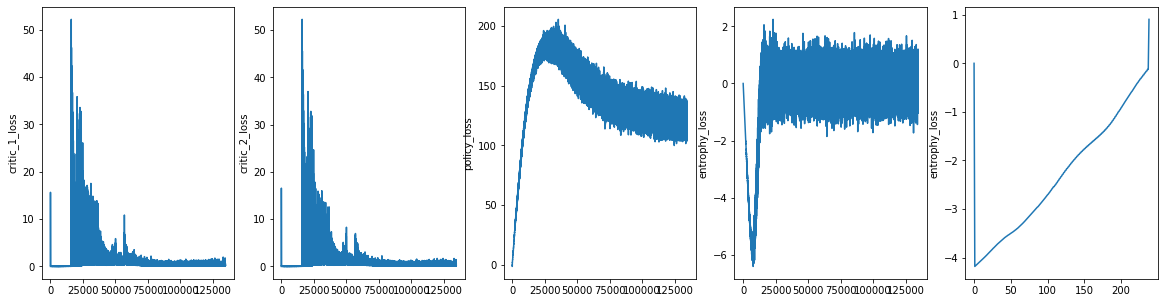

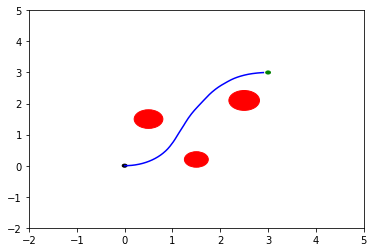

Episodes: 181, total_numsteps: 67601, episode steps: 0, reward: 0, curr. cost: 0, memory: 67601, memory_model: 336400
Episodes: 181, total_numsteps: 67651, episode steps: 50, reward: -3.5, curr. cost: 3.542, memory: 67651, memory_model: 336650
Episodes: 181, total_numsteps: 67701, episode steps: 100, reward: -2.696, curr. cost: 2.729, memory: 67701, memory_model: 336900
Episodes: 181, total_numsteps: 67751, episode steps: 150, reward: -1.757, curr. cost: 1.779, memory: 67751, memory_model: 337150
Episodes: 181, total_numsteps: 67801, episode steps: 200, reward: -0.874, curr. cost: 0.885, memory: 67801, memory_model: 337400
Episodes: 182, total_numsteps: 67835, episode steps: 0, reward: 0, curr. cost: 0, memory: 67835, memory_model: 337575
Episodes: 182, total_numsteps: 67885, episode steps: 50, reward: -3.497, curr. cost: 3.539, memory: 67885, memory_model: 337825
Episodes: 182, total_numsteps: 67935, episode steps: 100, reward: -2.7, curr. cost: 2.733, memory: 67935, memory_model: 338

In [11]:
hist_state, hist_action, hist_pi, hist_r, hist_episode_r, hist_cost, hist_episode = train(agent, env, model, seed, num_episode, Qbas)

In [12]:
import pickle  
# np.save('hist_state_bas_200_log_target01_Qbas1_lr3e4_update2.npy', hist_state, allow_pickle=True)
# np.save('hist_action_bas_200_log_target01_Qbas1_lr3e4_update2.npy', hist_action, allow_pickle=True)
# np.save('hist_r_bas_200_log_target01_Qbas1_lr3e4_update2.npy', hist_r, allow_pickle=True)
# np.save('hist_r_eps_bas_200_log_target01_Qbas1_lr3e4_update2.npy', hist_episode_r, allow_pickle=True)
# np.save('hist_cost_bas_200_log_target01_Qbas1_lr3e4_update2.npy', hist_cost, allow_pickle=True)
# np.save('hist_episode_bas_200_log_target01_Qbas1_lr3e4_update2.npy', hist_episode, allow_pickle=True)

/home/mkim815/anaconda3/envs/env39/lib/python3.9/site-packages/numpy/lib/npyio.py:518: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


Text(0, 0.5, 'steps')

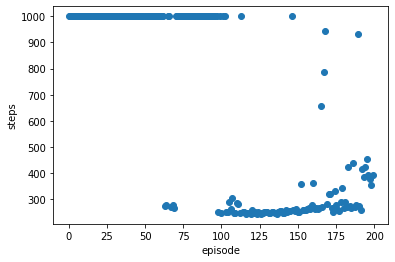

In [ ]:
plt.plot(hist_episode, 'o')
plt.xlabel("episode")
plt.ylabel("steps")

In [8]:
# hist_state_final = np.load('hist_state_bas_200_log_target01_Qbas1_lr3e4_update2.npy', allow_pickle=True)
# hist_action_final = np.load('hist_action_bas_200_log_target01_Qbas1_lr3e4_update2.npy', allow_pickle=True)
# hist_cost_final = np.load('hist_cost_bas_200_log_target01_Qbas1_lr3e4_update2.npy', allow_pickle=True)

Text(0.5, 1.0, 'cost')

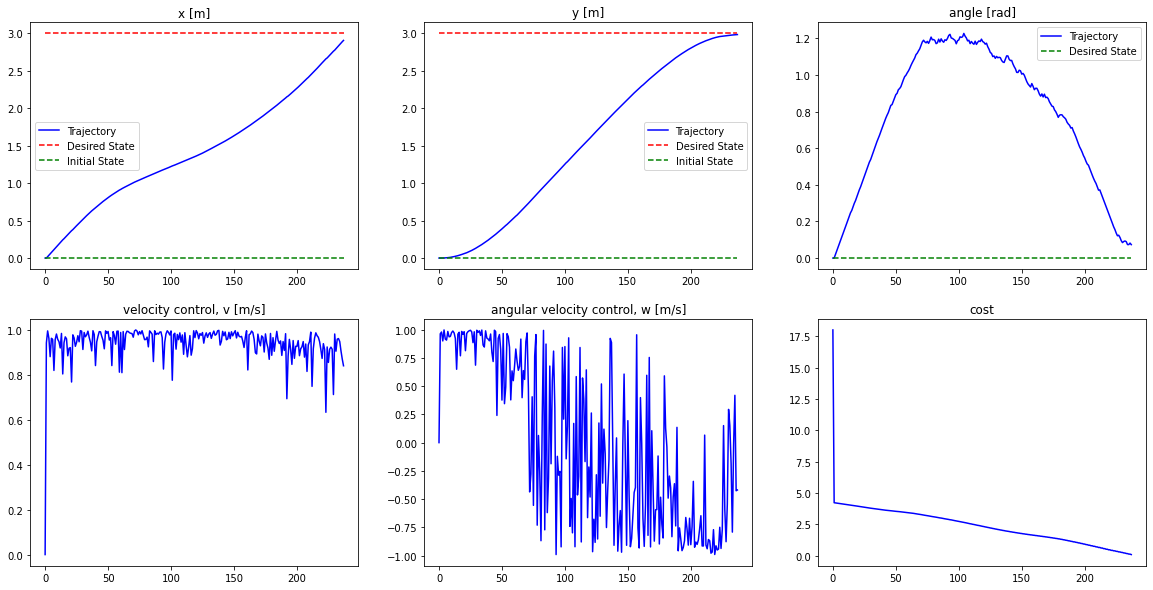

In [20]:
k = 199
fig1, ax1 = plt.subplots(2, 3, figsize=(20,10))
ax1[0, 0].plot(hist_state_final[k][:, 0], 'b')
ax1[0, 0].plot(np.ones(len(hist_state_final[k][:, 0]))*env.desired_pos[0], 'r--')
ax1[0, 0].plot(np.ones(len(hist_state_final[k][:, 0]))*env.initial_state[0], 'g--')
ax1[0, 0].set_title("x [m]")
ax1[0, 0].legend(["Trajectory", "Desired State", "Initial State"])


ax1[0, 1].plot(hist_state_final[k][:, 1], 'b')
ax1[0, 1].plot(np.ones(len(hist_state_final[k][:, 1]))*env.desired_pos[1], 'r--')
ax1[0, 1].plot(np.ones(len(hist_state_final[k][:, 1]))*env.initial_state[1], 'g--')
ax1[0, 1].set_title("y [m]")
ax1[0, 1].legend(["Trajectory", "Desired State", "Initial State"])

ax1[0, 2].plot(hist_state_final[k][:, 2], 'b')
ax1[0, 2].plot(np.ones(len(hist_state_final[k][:, 2]))*env.desired_pos[2], 'g--')
ax1[0, 2].set_title("angle [rad]")
ax1[0, 2].legend(["Trajectory", "Desired State"])

ax1[1, 0].plot(hist_action_final[k][:, 0], 'b')
ax1[1, 0].set_title("velocity control, v [m/s]")

ax1[1, 1].plot(hist_action_final[k][:, 1], 'b')
ax1[1, 1].set_title("angular velocity control, w [m/s]")

ax1[1, 2].plot(hist_cost_final[k], 'b')
ax1[1, 2].set_title("cost")


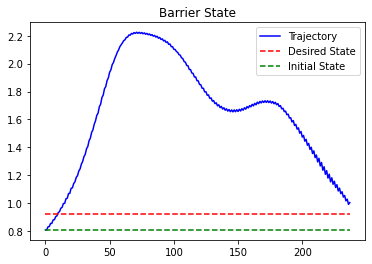

In [21]:
plt.plot((hist_state_final[k][:, 3]), 'b')
plt.plot(np.ones(len(hist_state_final[k][:, 3]))*(env.desired_pos[3]), 'r--')
plt.plot(np.ones(len(hist_state_final[k][:, 3]))*(env.initial_state[3]), 'g--')
plt.title("Barrier State")
plt.legend(["Trajectory", "Desired State", "Initial State"])

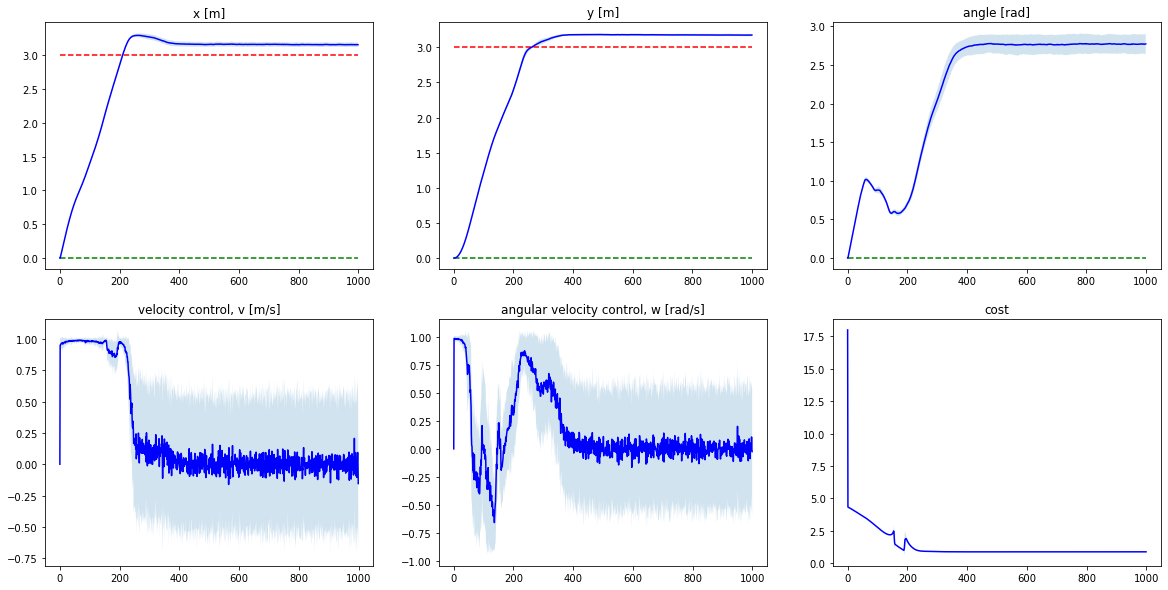

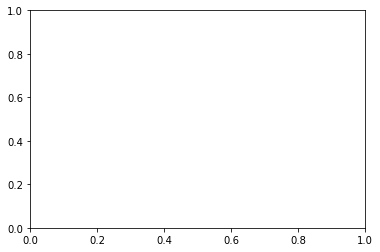

In [ ]:
fig1, ax1 = plt.subplots(2, 3, figsize=(20,10))
fig2, ax2 = plt.subplots(1)

ax1[0, 0].plot(np.ones(len(hist_state[0][:, 0]))*env.desired_pos[0], 'r--')
ax1[0, 0].plot(np.ones(len(hist_state[0][:, 0]))*env.initial_state[0], 'g--')
ax1[0, 0].set_title("x [m]")

ax1[0, 1].plot(np.ones(len(hist_state[0][:, 1]))*env.desired_pos[1], 'r--')
ax1[0, 1].plot(np.ones(len(hist_state[0][:, 0]))*env.initial_state[1], 'g--')
ax1[0, 1].set_title("y [m]")
 
ax1[0, 2].plot(np.ones(len(hist_state[0][:, 2]))*env.desired_pos[2], 'g--')
ax1[0, 2].set_title("angle [rad]")

ax1[1, 0].set_title("velocity control, v [m/s]")

ax1[1, 1].set_title("angular velocity control, w [rad/s]")

ax1[1, 2].set_title("cost")      

state1_mean = np.zeros(1000)
state1_std= np.zeros(1000)

state2_mean= np.zeros(1000)
state2_std= np.zeros(1000)

state3_mean= np.zeros(1000)
state3_std= np.zeros(1000)

state4_mean= np.zeros(1000)
state4_std= np.zeros(1000)

action1_mean= np.zeros( 1000)
action1_std= np.zeros(1000)
action2_mean= np.zeros( 1000)
action2_std= np.zeros( 1000)
cost_mean= np.zeros( 1000)
cost_std= np.zeros(1000)

thres = 100
#num_episode = 204
for k in range(1000):
    tmp_state1 = np.array([])
    tmp_state2 = np.array([])
    tmp_state3 = np.array([])
    tmp_state4 = np.array([])
    tmp_action1 = np.array([])
    tmp_action2 = np.array([])
    tmp_cost = np.array([])

    for h in range(num_episode):
        if h >= thres and h < thres + 100: 
            if k < int(hist_episode[h]):
                tmp_state1 = np.append(tmp_state1, hist_state[h][k, 0])
                tmp_state2 = np.append(tmp_state2, hist_state[h][k, 1])
                tmp_state3 = np.append(tmp_state3, hist_state[h][k, 2])
                if mode == 'BaS':
                    tmp_state4 = np.append(tmp_state4, hist_state[h][k, 3])
                tmp_action1 = np.append(tmp_action1, hist_action[h][k, 0])
                tmp_action2 = np.append(tmp_action2, hist_action[h][k, 1])
                tmp_cost = np.append(tmp_cost, hist_cost[h][k])
    
    state1_mean[k] = np.mean(tmp_state1)    
    state1_std[k] = np.std(tmp_state1)    

    state2_mean[k] = np.mean(tmp_state2)
    state2_std[k] = np.std(tmp_state2)   

    state3_mean[k] = np.mean(tmp_state3)
    state3_std[k] = np.std(tmp_state3)   
    
    if mode == 'BaS':
        state4_mean[k] = np.mean(tmp_state4)
        state4_std[k] = np.std(tmp_state4)   

    action1_mean[k] = np.mean(tmp_action1)
    action1_std[k] = np.std(tmp_action1)   

    action2_mean[k] = np.mean(tmp_action2)
    action2_std[k] = np.std(tmp_action2)   

    cost_mean[k] = np.mean(tmp_cost)
    cost_std[k] = np.std(tmp_cost)   
    
      
ax1[0, 0].plot(state1_mean, 'b')
ax1[0, 0].fill_between(range(1000), state1_mean-state1_std, state1_mean+state1_std, alpha=.2)
ax1[0, 1].plot(state2_mean, 'b')
ax1[0, 1].fill_between(range(1000), state2_mean-state2_std, state2_mean+state2_std, alpha=.2)
ax1[0, 2].plot(state3_mean, 'b')
ax1[0, 2].fill_between(range(1000), state3_mean-state3_std, state3_mean+state3_std, alpha=.2)
ax1[1, 0].plot(action1_mean, 'b')
ax1[1, 0].fill_between(range(1000), action1_mean-action1_std, action1_mean+action1_std, alpha=.2)
ax1[1, 1].plot(action2_mean, 'b')
ax1[1, 1].fill_between(range(1000), action2_mean-action2_std, action2_mean+action2_std, alpha=.2)
ax1[1, 2].plot(cost_mean, 'b')
ax1[1, 2].fill_between(range(1000), cost_mean-cost_std, cost_mean+cost_std, alpha=.2)

if mode == 'BaS':
    ax2.plot(state4_mean, 'b')
    ax2.fill_between(range(1000), state4_mean-state4_std, state4_mean+state4_std, alpha=.2)
    ax2.plot(np.ones(len(hist_state[0][:, 1]))*env.desired_pos[3], 'r--')
    ax2.plot(np.ones(len(hist_state[0][:, 0]))*env.initial_state[3], 'g--')


Text(0, 0.5, 'entrophy_loss')

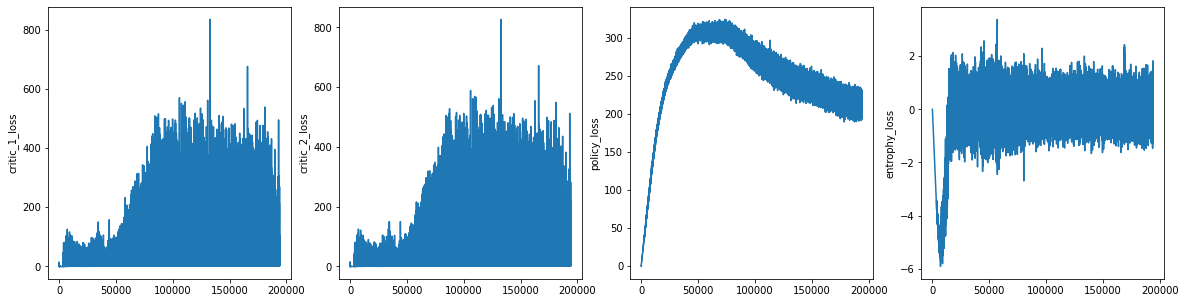

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20,5))
ax[0].plot(hist_pi[:, 0])
ax[0].set_ylabel("critic_1_loss")
ax[1].plot(hist_pi[:, 1])
ax[1].set_ylabel("critic_2_loss")
ax[2].plot(hist_pi[:, 2])
ax[2].set_ylabel("policy_loss")
ax[3].plot(hist_pi[:, 3])
ax[3].set_ylabel("entrophy_loss")

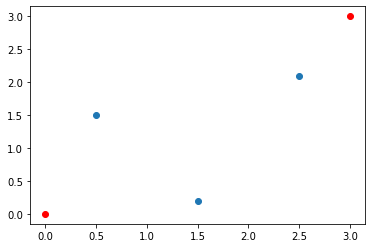

In [ ]:
plt.plot([0.5, 1.5, 2.5], [1.5, 0.2, 2.1], 'o')
plt.plot([0.0, 3.0], [0.0, 3.], 'ro')

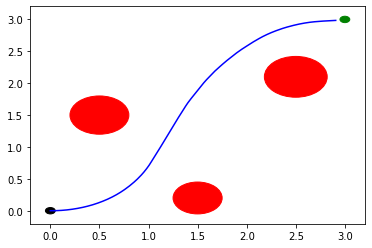

In [22]:
import numpy as np
import matplotlib.pyplot as plt

#hist_state_bas1_update2 = np.load('hist_state_bas_200_log_target01_Qbas1_lr3e4_update2.npy', allow_pickle=True)
ax = plt.gca()
ax.cla() # clear things for fresh plot
k = 199

plt.plot(hist_state_final[k][:, 0], hist_state_final[k][:, 1], 'b')

for n_obs in range(num_obs):
    circle = plt.Circle((env.obs_loc[n_obs][:2]), env.obs_loc[n_obs][2], color='r')
    ax.add_patch(circle)

init_point = plt.Circle((env.initial_state[:2]), 0.05, color='k')
des_point = plt.Circle((env.desired_pos[:2]), 0.05, color='g')
ax.add_patch(des_point)   
ax.add_patch(init_point)
plt.show()
#fig.savefig('traj.png')

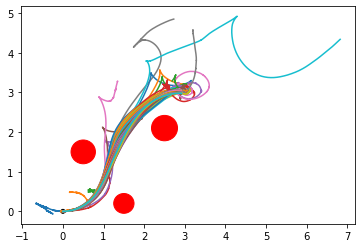

In [15]:
import numpy as np
import matplotlib.pyplot as plt

#hist_state_bas1_update2 = np.load('hist_state_bas_200_log_target01_Qbas1_lr3e4_update2.npy', allow_pickle=True)
ax = plt.gca()
ax.cla() # clear things for fresh plot

thres = 0
for n_obs in range(num_obs):
    circle = plt.Circle((env.obs_loc[n_obs][:2]), env.obs_loc[n_obs][2], color='r')
    ax.add_patch(circle)
    
for k in range(num_episode):
    if k < thres + 100 and k >= thres:
        plt.plot(hist_state_bas1_update2[k][:, 0], hist_state_bas1_update2[k][:, 1])


init_point = plt.Circle((env.initial_state[:2]), 0.05, color='k')
des_point = plt.Circle((env.desired_pos[:2]), 0.05, color='g')
ax.add_patch(des_point)   
ax.add_patch(init_point)
plt.show()
#fig.savefig('plotcircles2.png')

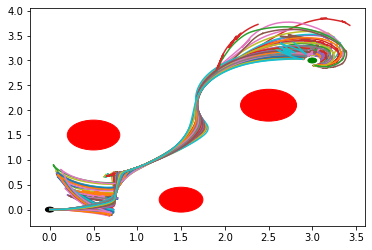

In [ ]:
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns

hist_r_cbf = np.load('data/hist_r_cbf_200_target01.npy', allow_pickle=True)
hist_state_cbf = np.load('data/hist_state_cbf_200_target01.npy', allow_pickle=True)

ax = plt.gca()
ax.cla() # clear things for fresh plot
num_obs = 3
thres = 100

for n_obs in range(num_obs):
    circle = plt.Circle((env.obs_loc[n_obs][:2]), env.obs_loc[n_obs][2], color='r')
    ax.add_patch(circle)
num_episode = 200
for k in range(num_episode):
    if k < thres + 100 and k >= thres:
        plt.plot(hist_state_cbf[k][:, 0], hist_state_cbf[k][:, 1])


init_point = plt.Circle((env.initial_state[:2]), 0.05, color='k')
des_point = plt.Circle((env.desired_pos[:2]), 0.05, color='g')
ax.add_patch(des_point)   
ax.add_patch(init_point)
plt.show()
#fig.savefig('plotcircles2.png')


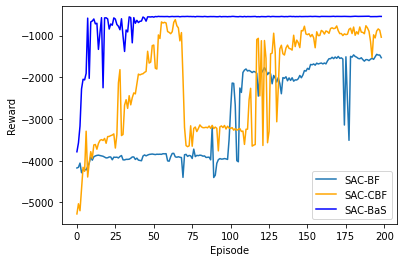

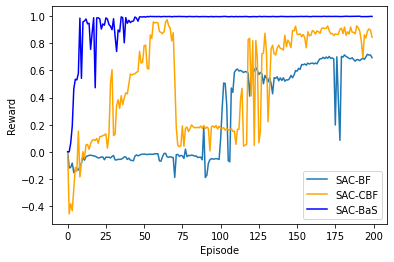

In [13]:
hist_r_eps_bas_update2 = np.load('data/hist_r_eps_bas_200_log_target01_Qbas1_lr3e4_update2.npy', allow_pickle=True)
hist_r_eps_cbf = np.load('data/hist_r_eps_cbf_200_target01.npy', allow_pickle=True)
hist_r_eps_bf = np.load('data/hist_r_eps_bf_200_log_target01.npy', allow_pickle=True)

r_max_cbf = np.zeros(num_episode)
r_max_bas = np.zeros(num_episode)
r_max_bf = np.zeros(num_episode)

thres = 0
tmp_reward = np.zeros((1, 3))
for h in range(num_episode):    
    r_max_cbf = hist_r_eps_cbf[h][-1]
    r_max_bas = hist_r_eps_bas_update2[h][-1]
    r_max_bf = hist_r_eps_bf[h][-1]

    if h > thres:
        tmp_reward = np.vstack((tmp_reward, np.array([r_max_bf[0], r_max_cbf[0], r_max_bas[0]])))

plt.plot(range(num_episode-1), tmp_reward[1:, 0])
plt.plot(range(num_episode-1), tmp_reward[1:, 1], 'orange')
plt.plot(range(num_episode-1), tmp_reward[1:, 2], 'b')
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend(["SAC-BF", "SAC-CBF", "SAC-BaS"])
plt.show()   

minVal = np.min(tmp_reward[1:, 2])
maxVal = np.max(tmp_reward[1:, 2])
tmp_reward_norm = np.zeros((1, 3))

for k in range(num_episode - 1): 
    hist_r_norm_bf = (tmp_reward[k+1, 0] - minVal) / (maxVal - minVal)
    hist_r_norm_cbf = (tmp_reward[k+1, 1] - minVal) / (maxVal - minVal)
    hist_r_norm_bas = (tmp_reward[k+1, 2] - minVal) / (maxVal - minVal)
    tmp_reward_norm = np.vstack((tmp_reward_norm, np.array([hist_r_norm_bf, hist_r_norm_cbf, hist_r_norm_bas])))

plt.plot(range(num_episode), tmp_reward_norm[:, 0])
plt.plot(range(num_episode), tmp_reward_norm[:, 1], 'orange')
plt.plot(range(num_episode), tmp_reward_norm[:, 2], 'b')

plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend(["SAC-BF", "SAC-CBF", "SAC-BaS"])
plt.show()   

In [ ]:
## ANIMATION
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib.animation import FuncAnimation
# from IPython import display
# import matplotlib.animation as animation
# import imageio  
# import os

# hist_state_bf = np.load('hist_state_bf_200_log_target01_Qbas001.npy', allow_pickle=True)
# hist_state_cbf = np.load('hist_state_cbf_200_target01.npy', allow_pickle=True)

# thres = 190
# n_frames = 5
# filenames = []
# for k in range(num_episode):
#     if k < thres + 200: # and k >= thres:
#         fig, ax = plt.subplots()
#         ax.cla() # clear things for fresh plot
#         ax.set_ylim((-2, 5))
#         ax.set_xlim((-2, 5))
#         ax.set_title('SAC-CBF Episode: {}'.format(k))
#         for i in range(n_frames):
#             for n_obs in range(num_obs):
#                 circle = plt.Circle((env.obs_loc[n_obs][:2]), env.obs_loc[n_obs][2], color='r')
#                 ax.add_patch(circle)
#             init_point = plt.Circle((env.initial_state[:2]), 0.05, color='k')
#             des_point = plt.Circle((env.desired_pos[:2]), 0.05, color='g')
                    
#             #fig.savefig('plotcircles2.png')
#             ax.add_patch(des_point)   
#             ax.add_patch(init_point)
#             ax.plot(hist_state_cbf[k][:, 0], hist_state_cbf[k][:, 1])
#             filename = f'{k}.png'
#             filenames.append(filename)
#             fig.savefig(filename, dpi=200)
#             plt.close()
        
# with imageio.get_writer('cbf_sim.gif', mode='I') as writer:
#     for filename in filenames:
#         image = imageio.imread(filename)
#         writer.append_data(image)

# for filename in set(filenames):
#     os.remove(filename)

/tmp/ipykernel_352/1437928084.py:51: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
